In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from torch.utils.data import DataLoader
import csv
import torch

# num_users:      the number of clients you want to distributed data to
# nclass:         the number of image classes each client has
# nsamples:       number of samples per class distributed to clients
# rate_unbalance: unbalanced rate of non-iid MNIST and CIFAR10 dataset

In [2]:
def get_dataset_cifar10_extr_noniid(num_users, n_class, nsamples, rate_unbalance):
    data_dir = '../data/cifar/'
    apply_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    train_dataset = datasets.CIFAR10(data_dir, train=True, download=True,
                                   transform=apply_transform)

    test_dataset = datasets.CIFAR10(data_dir, train=False, download=True,
                                      transform=apply_transform)

    # Chose euqal splits for every user
    user_groups_train, user_groups_test = cifar_extr_noniid(train_dataset, test_dataset, num_users, n_class, nsamples, rate_unbalance)
    return train_dataset, test_dataset, user_groups_train, user_groups_test

In [34]:
# from dataset.cifar10_noniid import get_dataset_cifar10_extr_noniid
num_users_cifar = 5
nclass_cifar = 4
nsamples_cifar = 2500
rate_unbalance_cifar = 0.6

In [35]:
def cifar_extr_noniid(train_dataset, test_dataset, num_users, n_class, num_samples, rate_unbalance):
    num_shards_train, num_imgs_train = int(50000/num_samples), num_samples
    num_classes = 10
    num_imgs_perc_test, num_imgs_test_total = 1000, 10000
    assert(n_class * num_users <= num_shards_train)
    assert(n_class <= num_classes)
    idx_class = [i for i in range(num_classes)]
    idx_shard = [i for i in range(num_shards_train)]
    dict_users_train = {i: np.array([]) for i in range(num_users)}
    dict_users_test = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards_train*num_imgs_train)
    # labels = dataset.train_labels.numpy()
    labels = np.array(train_dataset.targets)
    idxs_test = np.arange(num_imgs_test_total)
    labels_test = np.array(test_dataset.targets)
    #labels_test_raw = np.array(test_dataset.targets)

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]
    labels = idxs_labels[1, :]

    idxs_labels_test = np.vstack((idxs_test, labels_test))
    idxs_labels_test = idxs_labels_test[:, idxs_labels_test[1, :].argsort()]
    idxs_test = idxs_labels_test[0, :]
    #print(idxs_labels_test[1, :])


    # divide and assign
    for i in range(num_users):
        user_labels = np.array([])
        rand_set = set(np.random.choice(idx_shard, n_class, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        unbalance_flag = 0
        for rand in rand_set:
            if unbalance_flag == 0:
                dict_users_train[i] = np.concatenate(
                    (dict_users_train[i], idxs[rand*num_imgs_train:(rand+1)*num_imgs_train]), axis=0)
                user_labels = np.concatenate((user_labels, labels[rand*num_imgs_train:(rand+1)*num_imgs_train]), axis=0)
            else:
                dict_users_train[i] = np.concatenate(
                    (dict_users_train[i], idxs[rand*num_imgs_train:int((rand+rate_unbalance)*num_imgs_train)]), axis=0)
                user_labels = np.concatenate((user_labels, labels[rand*num_imgs_train:int((rand+rate_unbalance)*num_imgs_train)]), axis=0)
            unbalance_flag = 1
        user_labels_set = set(user_labels)
        #print(user_labels_set)
        #print(user_labels)
        for label in user_labels_set:
            dict_users_test[i] = np.concatenate((dict_users_test[i], idxs_test[int(label)*num_imgs_perc_test:int(label+1)*num_imgs_perc_test]), axis=0)
        #print(set(labels_test_raw[dict_users_test[i].astype(int)]))

    return dict_users_train, dict_users_test

In [36]:
train_dataset_cifar, test_dataset_cifar, user_groups_train_cifar, user_groups_test_cifar = get_dataset_cifar10_extr_noniid(num_users_cifar, nclass_cifar, nsamples_cifar, rate_unbalance_cifar)

Files already downloaded and verified
Files already downloaded and verified


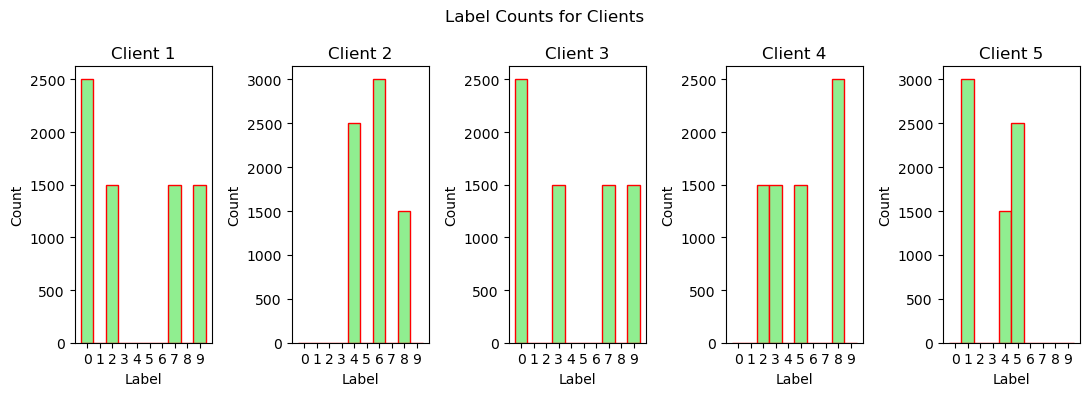

In [37]:
fig = plt.figure(figsize=(11, 4))
fig.suptitle('Label Counts for Clients')
bins = np.arange(11) - 0.5

for idx in range(num_users_cifar):
    label_list = []
    for idx1 in user_groups_train_cifar[idx]:
        label_list.append(train_dataset_cifar.targets[int(idx1)])
#     print (label_list)
    plt.subplot(1,5, idx+1)   
    plt.title('Client {}'.format(idx+1))
    counts, edges, bars = plt.hist(label_list, density=False, bins=bins, color = "lightgreen", ec="red")  
    # density=False would make counts
#     plt.bar_label(bars)
    plt.ylabel('Count')
    plt.xlabel('Label')
    plt.xticks(range(10))
plt.tight_layout()
plt.show()
#     plt.show()

In [38]:
user_groups_train_cifar

{0: array([29513., 16836., 32316., ...,   652., 27217., 27226.]),
 1: array([ 3189., 49669., 23337., ...,  4278., 10213., 16546.]),
 2: array([19740.,  6761., 26376., ..., 14939., 24416., 14944.]),
 3: array([36324., 26703., 26714., ..., 13976.,  8386.,  8385.]),
 4: array([ 4702., 32055., 34524., ..., 32042., 32083., 32087.])}

In [39]:
print ("Train eg per client: ",len(user_groups_train_cifar[3]))
print ("Test eg per client: ",len(user_groups_test_cifar[2]))

Train eg per client:  7000
Test eg per client:  4000


In [40]:
set_train1 = set((user_groups_train_cifar[0]).tolist())
set_train2 = set(user_groups_train_cifar[1].tolist())
set_train3 = set(user_groups_train_cifar[2].tolist())
set_train4 = set(user_groups_train_cifar[3].tolist())

In [41]:
set_common = set_train4.intersection(set_train2)
set_common

set()

In [42]:
set_test1 = set((user_groups_test_cifar[0]).tolist())
set_test2 = set(user_groups_test_cifar[1].tolist())
set_test3 = set(user_groups_test_cifar[2].tolist())
set_test4 = set(user_groups_test_cifar[3].tolist())
len(set_test4)

4000

In [249]:
set_common = set_test2.intersection(set_test1)
len(set_common)

2000

In [267]:
trainset1 = train_dataset_cifar[0]
testset1 = test_dataset_cifar[0]

In [268]:
def load_data():
    """Load CIFAR-10 (training and test set)."""
    trf = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = CIFAR10(trainset1, train=True, download=True, transform=trf)
    testset = CIFAR10(testset1, train=False, download=True, transform=trf)
    return DataLoader(trainset, batch_size=32, shuffle=True), DataLoader(testset)

In [271]:
train_dataloader = DataLoader(trainset1, batch_size=16, shuffle=True)
test_dataloader = DataLoader(testset1, batch_size=16, shuffle=True)

In [277]:
print (type(train_dataset_cifar[0]))

<class 'tuple'>


In [282]:
outfile = 'train_temp1.pt'
torch.save(trainset1, outfile)

In [285]:
trainset_pt1 = torch.load(outfile)


In [300]:
(trainset_pt1[2].size())

IndexError: tuple index out of range

In [299]:
trainset_pt1.index

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

In [298]:
print (trainset_pt1)

(tensor([[[-1.2854e+00, -1.5955e+00, -1.4598e+00,  ...,  6.3375e-01,
           5.1744e-01,  4.3990e-01],
         [-2.1189e+00, -2.4291e+00, -2.0801e+00,  ..., -4.4721e-02,
          -1.2226e-01, -6.4106e-02],
         [-1.9444e+00, -2.1189e+00, -1.4792e+00,  ..., -1.4165e-01,
          -1.0288e-01, -3.1611e-01],
         ...,
         [ 1.6030e+00,  1.4673e+00,  1.4091e+00,  ...,  6.7252e-01,
          -1.3435e+00, -1.4017e+00],
         [ 1.0602e+00,  9.2452e-01,  1.1765e+00,  ...,  1.1378e+00,
          -5.4873e-01, -8.2012e-01],
         [ 1.0021e+00,  8.2760e-01,  1.0408e+00,  ...,  1.7581e+00,
           4.9806e-01, -4.4721e-02]],

        [[-1.1989e+00, -1.5136e+00, -1.4742e+00,  ...,  1.7777e-01,
           4.0101e-02,  2.0434e-02],
         [-2.0249e+00, -2.4183e+00, -2.2609e+00,  ..., -6.8757e-01,
          -7.8591e-01, -7.0724e-01],
         [-1.9463e+00, -2.2806e+00, -1.8873e+00,  ..., -7.6624e-01,
          -7.6624e-01, -9.8258e-01],
         ...,
         [ 9.2511e-01,  

In [305]:
type(train_dataset_cifar.data)

numpy.ndarray

In [306]:
type(user_groups_train_cifar)

dict

In [307]:
torch.save(user_groups_train_cifar, 'user_group.pt')

In [344]:
outfile = 'data_split/train_temp1.pt'
torch.save(train_dataset_cifar.data, outfile)

In [313]:
trainset1 = []
for idx in user_groups_train_cifar[0]:
    print (idx)
#     trainset1.append(train_dataset_cifar.data[int(idx)])

# print (trainset1)
    

43818.0
43710.0
43609.0
43608.0
43605.0
43394.0
43398.0
43413.0
43416.0
43417.0
43447.0
43453.0
43457.0
43480.0
43514.0
43518.0
43519.0
43520.0
43547.0
43555.0
43583.0
43585.0
43600.0
43602.0
44571.0
35878.0
44575.0
44591.0
45613.0
45628.0
45642.0
45655.0
45672.0
45675.0
45677.0
45685.0
45602.0
45687.0
45714.0
45715.0
45736.0
45768.0
45769.0
45780.0
45787.0
45810.0
45704.0
45821.0
45600.0
45584.0
45434.0
45444.0
45455.0
45466.0
45470.0
45475.0
45483.0
45485.0
45599.0
45487.0
45500.0
45535.0
45548.0
45565.0
45567.0
45569.0
45574.0
45580.0
45488.0
45427.0
45834.0
45859.0
46162.0
46173.0
46177.0
46194.0
46206.0
46207.0
46213.0
46219.0
46147.0
46233.0
46238.0
46240.0
46259.0
46268.0
46279.0
46281.0
46304.0
46323.0
46237.0
45856.0
46140.0
46127.0
45866.0
45877.0
45899.0
45910.0
45923.0
45946.0
45968.0
45972.0
46135.0
45977.0
45988.0
46003.0
46026.0
46051.0
46060.0
46078.0
46099.0
46107.0
45979.0
45425.0
45406.0
45403.0
44835.0
44841.0
44854.0
44869.0
44870.0
44876.0
44886.0
44889.0
44828.0


In [319]:
train_dataset_cifar.targets[40020]

2

In [324]:
trainset1 = train_dataset_cifar[20000]
trainset1

(tensor([[[-1.9251, -2.0995, -2.1771,  ..., -2.1383, -1.9638, -2.0026],
          [-2.0414, -2.1771, -2.1771,  ..., -2.0608, -2.0220, -1.8669],
          [-2.1577, -2.1771, -2.1771,  ..., -2.0995, -1.9444, -1.8281],
          ...,
          [-0.6844, -1.7700, -1.8863,  ..., -1.9832, -2.1189, -2.2546],
          [-0.8977, -1.3047, -1.8087,  ..., -2.1577, -2.1189, -2.2352],
          [ 0.0522, -1.3047, -1.9444,  ..., -2.1771, -2.1964, -2.1771]],
 
         [[-1.9659, -2.1429, -2.2413,  ..., -2.1429, -1.9463, -2.0053],
          [-2.0839, -2.2216, -2.2413,  ..., -2.0839, -2.0249, -1.8479],
          [-2.2019, -2.2216, -2.2413,  ..., -2.1036, -1.9463, -1.8086],
          ...,
          [-0.2746, -1.1596, -1.3562,  ..., -2.0249, -2.1626, -2.3003],
          [-0.3532, -0.5302, -1.0809,  ..., -2.2019, -2.1626, -2.2806],
          [ 0.6694, -0.5892, -1.2382,  ..., -2.2216, -2.2413, -2.2216]],
 
         [[-1.5971, -1.7336, -1.7531,  ..., -1.6751, -1.4995, -1.5580],
          [-1.7141, -1.7922,

In [347]:
# Save data for each client to separate file
# Client 1
train_client1 = []
test_client1 = []
for idx in user_groups_train_cifar[0]:
    train_client1.append(train_dataset_cifar[int(idx)])

for idx1 in user_groups_test_cifar[0]:
    test_client1.append(test_dataset_cifar[int(idx1)])
    

torch.save(train_client1, 'data_split/training_data_client1.pt')
torch.save(test_client1, 'data_split/testing_data_client1.pt')
    

In [348]:
# Client 2
train_client2 = []
test_client2 = []
for idx in user_groups_train_cifar[1]:
    train_client2.append(train_dataset_cifar[int(idx)])

for idx1 in user_groups_test_cifar[1]:
    test_client2.append(test_dataset_cifar[int(idx1)])
    

torch.save(train_client2, 'data_split/training_data_client2.pt')
torch.save(test_client2, 'data_split/testing_data_client2.pt')

# Client 3
train_client3 = []
test_client3 = []
for idx in user_groups_train_cifar[2]:
    train_client3.append(train_dataset_cifar[int(idx)])

for idx1 in user_groups_test_cifar[2]:
    test_client3.append(test_dataset_cifar[int(idx1)])
    

torch.save(train_client3, 'data_split/training_data_client3.pt')
torch.save(test_client3, 'data_split/testing_data_client3.pt')

# Client 4
train_client4 = []
test_client4 = []
for idx in user_groups_train_cifar[3]:
    train_client4.append(train_dataset_cifar[int(idx)])

for idx1 in user_groups_test_cifar[3]:
    test_client4.append(test_dataset_cifar[int(idx1)])
    

torch.save(train_client4, 'data_split/training_data_client4.pt')
torch.save(test_client4, 'data_split/testing_data_client4.pt')

In [352]:
len(test_client3)

5000

In [358]:
def load_data():
    """Load CIFAR-10 (training and test set) from data_split folder"""
    train_path = "data_split/training_data_client1.pt"
    test_path = "data_split/testing_data_client1.pt"
    trainset = torch.load(train_path)
    testset = torch.load(test_path)
    trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
    testloader = DataLoader(testset, batch_size=16, shuffle=True)
    num_examples = {"trainset" : len(trainset), "testset" : len(testset)}
    return trainloader, testloader

In [359]:
trainloader, testloader = load_data()